# speaker 별 발화 길이에 따른 output 내 요약 차지 비율 분석


- 샘플마다 speaker 별 발화 길이를 확인 -> 이 길이가 output에서도 동일하게 적용되는지 확인
    - 확인할 만 한 것 
        - speaker별 샘플내 utterance 개수
        - speaker별 샘플내 utterance 총 발화길이
        - speaker별 utterance 별 발화 길이 평균, 중앙값, 최대 최소

    - output 내 speaker별 요약에 해당하는 범위를 특정하기 위해 이름을 사용 (SD~ )
        - 이 SD가 첫번째 문장(전반적인 요약)을 제외한 그 뒤의 문장 내에서 몇 개 존재하는지 화깅ㄴ
        - 만약 2개가 존재하고 그 이름이 서로 다르다면,
            - 두 개의 문장으로 분할 가능

        - 만약 3개 이상이 존재한다면
            - 이는 직접 분석하여 어떻게 분리할 것인지 해봐야함

<br/>

- 샘플 output의 speaker별 요약 길이 
    - speaker 별 총 발화길이, speaker별 발화 길이 평균에 따른
        - speaker 별 요약 길이
        - 이 요약길이가 특정 범위 내에 존재한다면
        - prompt로 요약 길이 범위를 주어줄 수 있어서 매우 중요!!!!!!!!!
                
        - 그리고 이 길이 분포가 dev 데이터, test 데이터에 대해서도 동일하게 적용되는가?


        - 샘플내 발화(utterance) 길이와 요약 길이가 비례하는가?
            - 그렇지 않은 샘플이라면 어떤 특징을 가지는가?

## 샘플 내 speaker 별 발화 개수

In [71]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from transformers import AutoTokenizer
import re
from collections import defaultdict

In [72]:
def make_dataframe(path: str) -> pd.DataFrame:
    """
    Read a json file and return a pandas DataFrame.

    Parameters:
    path (str): Path to the json file.

    Returns:
    pd.DataFrame: DataFrame of the json file.
    """
    # Read the json file
    with open(path, 'r') as file:
        data = json.load(file)

    # Create a DataFrame
    # columns = ['id', 'conversation', 'subject_keyword', 'output']
    df = pd.DataFrame(data)
    df['conversation'] = df['input'].apply(lambda x: x['conversation'])
    df['subject_keyword'] = df['input'].apply(lambda x: x['subject_keyword'])

    # Drop the 'input' column
    df.drop('input', axis=1, inplace=True)

    # Speakers in the conversation
    df['speakers'] = df['conversation'].apply(lambda turns: list(set(turn['speaker'] for turn in turns)))

    # Reorder the columns
    df = df[['id', 'conversation', 'subject_keyword', 'speakers', 'output']]

    return df

In [73]:
train_df = make_dataframe('../resource/data/일상대화요약_train.json')
dev_df = make_dataframe('../resource/data/일상대화요약_dev.json')
test_df = make_dataframe('../resource/data/일상대화요약_test.json')
filtered_train_df = make_dataframe('./train.json')
filtered_dev_df = make_dataframe('./dev.json')
filtered_test_df = make_dataframe('./test.json')

In [99]:
def get_num_utterances_per_speaker(df: pd.DataFrame, test = None) -> pd.DataFrame:
    """
    Get the number of utterances per speaker in the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame of the data.
    """
    df = deepcopy(df)

    # Get the number of utterances per speaker
    def return_num_utterances_per_speaker(turns):
        speakers = [turn['speaker'] for turn in turns]
        if speakers is None:
            print("errror")
        return pd.Series(speakers).value_counts().to_dict()
    
    # Get the number of utterances per speaker
    df['num_utterances_per_speaker'] = df['conversation'].apply(return_num_utterances_per_speaker)
    
    # Get the first speaker in the conversation
    df['first_speaker'] = df['conversation'].apply(lambda x: x[0]['speaker'])
    # df['last_speaker'] = df['conversation'].apply(lambda x: x[-1]['speaker'])

    # Get the first speaker of speaker summary in the output
    if test is None:
        df['first_speaker_summary'] = df['output'].apply(lambda x : re.findall(r'SD\d{7}', x.split('.')[1]))

    return df

In [100]:
train_df = get_num_utterances_per_speaker(filtered_train_df)
dev_df = get_num_utterances_per_speaker(filtered_dev_df)
test_df = get_num_utterances_per_speaker(filtered_test_df, test = True)

In [101]:
train_df.head(1)

,id,conversation,subject_keyword,speakers,output,num_utterances_per_speaker,first_speaker,first_speaker_summary
0,nikluge-2024-일상 대화 요약-train-000001,"[{'speaker': 'SD2000001', 'utterance': '저는 여행 ...",[해외여행],"[SD2000002, SD2000001]",두 화자는 이 대화에서 좋았던 여행지와 기억나는 주요 명소에 대해 이야기했습니다. ...,"{'SD2000002': 8, 'SD2000001': 6}",SD2000001,[SD2000001]


- output summary의 맨 첫번째 speaker 요약에 해당하는 speaker 특징

In [108]:
def compare_speaker(row):
    """
    Compare the first speaker in the conversation and the first speaker in the speaker summary.
    """
    # Version 1
    # if row['first_speaker_summary'] == []:
    #     return False
    # return row['first_speaker_summary'][0] == row['first_speaker']
    
    # Version 2
    head_speaker = re.findall(r'SD\d{7}', row['output'])[0]
    return head_speaker == row['first_speaker']


print(train_df.apply(compare_speaker, axis = 1).value_counts())
print(dev_df.apply(compare_speaker, axis = 1).value_counts())

True     460
False     46
Name: count, dtype: int64
True     95
False     7
Name: count, dtype: int64


In [110]:
reversed_speaker_train_df = train_df[~train_df.apply(compare_speaker, axis = 1)]
def check_different_speaker(text:str):
    """
    Check if the first speaker in the conversation and the first speaker in the speaker summary are different.
    """
    headers = re.findall(r'SD\d{7}[은는]{1}', text)
    if len(headers) > 1:
        headers = set([header[:9] for header in headers])
        if len(headers) > 1:
            return False
        else:
            return True
    else:
        return True
reversed_speaker_train_df[reversed_speaker_train_df['output'].apply(check_different_speaker)]['output'].apply(lambda x: re.findall(r'SD\d{7}\w+', x))

26     [SD2000869는, SD2000870의]
475    [SD2110574는, SD2100573도]
Name: output, dtype: object

In [91]:
train_df['output'].iloc[26]

'두 화자는 이 대화에서 자식을 낳는 것에 대해 말했습니다. SD2000869는 본인이 딸들을 낳아 인생의 큰 기쁨이었다며 자녀들도 자식을 낳아 자녀로 인한 행복함을 누렸으면 좋겠다고 말했습니다. SD2000870의 지인은 자녀가 예쁘지만 키우면서 너무 힘들었기 때문에 자식을 낳는 것에 신중해야 하고 안 낳아도 된다고 생각하고 있다고 말했습니다.'

In [93]:
train_df['conversation'].iloc[475]

[{'speaker': 'SD2100573',
  'utterance': '그리고 우리 하와이 말고 제주도가 지금 당장 닥쳐 있잖아. 제주도 일정이 내가 너랑 거의 비슷하게 가는 거 같던데 맞나?'},
 {'speaker': 'SD2110574',
  'utterance': '난 언니가 언제 오는지는 모르겠고 우리가 오후 3시 비행기인 건 알고 있어.'},
 {'speaker': 'SD2100573',
  'utterance': '엄마가 너랑 나 비행기 시간이 비슷하게 해서 픽업을 한다고 했거든? 해서 아마 비슷할 거 같아.'},
 {'speaker': 'SD2110574',
  'utterance': '그러면은 비슷한 시간에 도착하겠다 내가 알기론 우리 도착하고 바로 거의 저녁 먹고 그냥 그날 일정은 그렇게 끝이고 다음 날에 우리 이거 사진작가 와 가지고 제주도 예쁜 곳 돌아다니면서 사진 많이 찍는다고 했었어.'},
 {'speaker': 'SD2100573',
  'utterance': '맞아 엄마가 그거 준비한다고 티셔츠도 사고 너한테 신발도 사 오라고 하고 그랬는데 특히 티셔츠는 너무 추워져서 못 입을 거 같아 사진 찍을 때.'},
 {'speaker': 'SD2110574', 'utterance': '근데 제주도는 한 20도쯤 된대 그때.'},
 {'speaker': 'SD2100573', 'utterance': '야 진짜 지금 보다 1주일 뒨데 그렇게 따뜻하다니 신기하다.'},
 {'speaker': 'SD2110574',
  'utterance': '그리고 그냥 외투도 여러 가지 겹쳐 입 걸쳐서 입고 그러면은 괜찮지 않을까 싶어.'},
 {'speaker': 'SD2100573', 'utterance': '이번에 엄마가 보내준 것도 가족 여행용으로 보내 준 외투야?'},
 {'speaker': 'SD2110574', 'utterance': '어떤 거?'},
 {'speaker': 'SD2100573', 'utterance': '아이 아이보 베이지색

In [92]:
train_df['output'].iloc[475]

'두 화자는 이 대화에서 엄마와 함께 가는 제주도 여행에 관해 이야기했습니다. 두 화자는 오후 3시 비행기를 타고 제주도에 도착해 저녁을 먹고 다음 날 엄마가 섭외한 사진 작가와 함께 제주도 야외 예쁜 장소들을 돌아다니며 사진을 찍는다고 이야기했습니다. SD2110574는 제주도에 가면 꼭 먹고 싶은 음식이 있었는데 엄마가 미리 식당을 예약해 놓아서 아쉽다고 했으며 SD2100573도 엄마의 모든 일정에 참여하는 것이 싫다고 이야기했으며 제주도에 가면 승마를 하고 싶다고 말했습니다.'

- train의 [475] [SD2110574는, SD2100573도] 에서 
    - SD2100573도 -> SD2100573은

In [109]:
print(dev_df.apply(compare_speaker, axis = 1).value_counts())
reversed_speaker_dev_df = dev_df[~dev_df.apply(compare_speaker, axis = 1)]
reversed_speaker_dev_df[reversed_speaker_dev_df['output'].apply(check_different_speaker)]

True     95
False     7
Name: count, dtype: int64


,id,conversation,subject_keyword,speakers,output,num_utterances_per_speaker,first_speaker,first_speaker_summary


<br/>

In [65]:
train_df['first_speaker_summary'].apply(lambda x : len(x)).value_counts()

first_speaker_summary
2    470
3     30
0      4
4      2
Name: count, dtype: int64

In [61]:
dev_df['first_speaker_summary'].apply(lambda x : len(x)).value_counts()

first_speaker_summary
2    101
3      1
Name: count, dtype: int64

<br/>

<br/>

In [122]:
dev_df[dev_df['first_speaker_summary'].apply(lambda x : len(x)==2)]['output'].iloc[0]

'두 화자는 이 대화에서 생일 선물에 대해 말했습니다. SD2000859는 본인 동생도 SD2000860과 비슷하게 생일인 사람이 직접 밥을 사주는 데 좋은 방식인 것 같다고 했습니다. SD2000860은 생일인 사람이 밥을 사주는 편이며 받기보다 부모님께 감사해야 하는 날이라고 말했습니다. 어릴 때는 상대방처럼 선물 주고받는 걸 좋아했지만 요즘엔 선물을 주기보다는 생일날 함께 하기 위해 밥을 사준다고 말했습니다. 또 화자의 지인들이 생일에 받기보다 부모님께 감사 전화를 하는 것을 보면서 반성했다고 말했습니다.'

### output 두번째 문장에 speaker가 없는 경우
- 두 화자 모두 ~ 하다라는 문장이 나오는 경우가 있음

In [9]:
train_df[train_df['first_speaker_summary'].apply(lambda x : len(x) == 0)]['output'].apply(lambda x : x.split('.')[1])

59                               두 화자 모두 네 가족이라고 이야기했습니다
63              두 화자 모두 학교 다닐 때 친구들과의 관계에서 힘들었다고 이야기했습니다
261                두 화자 모두 형제와 친하거나 마음을 터 놓지는 않는다고 말했습니다
475     두 화자는 오후 3시 비행기를 타고 제주도에 도착해 저녁을 먹고 다음 날 엄마가 ...
Name: output, dtype: object

In [42]:
train_df[train_df['first_speaker_summary'].apply(lambda x : len(x) == 0)]['conversation'].iloc[3]

[{'speaker': 'SD2100573',
  'utterance': '그리고 우리 하와이 말고 제주도가 지금 당장 닥쳐 있잖아. 제주도 일정이 내가 너랑 거의 비슷하게 가는 거 같던데 맞나?'},
 {'speaker': 'SD2110574',
  'utterance': '난 언니가 언제 오는지는 모르겠고 우리가 오후 3시 비행기인 건 알고 있어.'},
 {'speaker': 'SD2100573',
  'utterance': '엄마가 너랑 나 비행기 시간이 비슷하게 해서 픽업을 한다고 했거든? 해서 아마 비슷할 거 같아.'},
 {'speaker': 'SD2110574',
  'utterance': '그러면은 비슷한 시간에 도착하겠다 내가 알기론 우리 도착하고 바로 거의 저녁 먹고 그냥 그날 일정은 그렇게 끝이고 다음 날에 우리 이거 사진작가 와 가지고 제주도 예쁜 곳 돌아다니면서 사진 많이 찍는다고 했었어.'},
 {'speaker': 'SD2100573',
  'utterance': '맞아 엄마가 그거 준비한다고 티셔츠도 사고 너한테 신발도 사 오라고 하고 그랬는데 특히 티셔츠는 너무 추워져서 못 입을 거 같아 사진 찍을 때.'},
 {'speaker': 'SD2110574', 'utterance': '근데 제주도는 한 20도쯤 된대 그때.'},
 {'speaker': 'SD2100573', 'utterance': '야 진짜 지금 보다 1주일 뒨데 그렇게 따뜻하다니 신기하다.'},
 {'speaker': 'SD2110574',
  'utterance': '그리고 그냥 외투도 여러 가지 겹쳐 입 걸쳐서 입고 그러면은 괜찮지 않을까 싶어.'},
 {'speaker': 'SD2100573', 'utterance': '이번에 엄마가 보내준 것도 가족 여행용으로 보내 준 외투야?'},
 {'speaker': 'SD2110574', 'utterance': '어떤 거?'},
 {'speaker': 'SD2100573', 'utterance': '아이 아이보 베이지색

In [43]:
train_df[train_df['first_speaker_summary'].apply(lambda x : len(x) == 0)]['output'].iloc[3]

'## 전반적인 요약\n두 화자는 이 대화에서 엄마와 함께 가는 제주도 여행에 관해 이야기했습니다. 두 화자는 오후 3시 비행기를 타고 제주도에 도착해 저녁을 먹고 다음 날 엄마가 섭외한 사진 작가와 함께 제주도 야외 예쁜 장소들을 돌아다니며 사진을 찍는다고 이야기했습니다.\n\n## SD2110574 요약\nSD2110574는 제주도에 가면 꼭 먹고 싶은 음식이 있었는데 엄마가 미리 식당을 예약해 놓아서 아쉽다고 했으며\n\n## SD2100573 요약\nSD2100573도 엄마의 모든 일정에 참여하는 것이 싫다고 이야기했으며 제주도에 가면 승마를 하고 싶다고 말했습니다.'

In [119]:
dev_df[dev_df['first_spekaer_summary'].apply(lambda x : len(x) == 0)]['output'].apply(lambda x : x.split('.')[1])

Series([], Name: output, dtype: object)

### output 두 번째 문장에 speaker가 2개 있는 경우

In [10]:
train_df[train_df['first_spekaer_summary'].apply(lambda x : len(x) == 2)]['output'].apply(lambda x : x.split('.')[1])

23      SD2000042는 SD2000043의 블로그에 올라온 토르티야 피자 이야기를 보...
28      SD2000871은 SD2000872와 같이 음악 방송을 보며 크래비티 멤버 중 ...
34          SD2000879는 SD2000878에게 제주도에서 삶의 고충에 대해 물었습니다
254     SD2002188은 SD2002191에게 서방님 때문에 스트레스 받았는데 괜찮은지...
255     SD2002191은 SD2002188에게 가족이라면 제일 떠오르는 게 뭔지 물었고...
258     SD2002231은 SD2002232에게 건강을 위해 챙겨 먹는 음식과 보조제, ...
262     SD2002290은 SD2002291에게 소심하지만, 친한 사람 중에서 활발하고 ...
330     SD2100471은 가지고 있는 아파트 지분을 팔고 상가를 사서 세를 줄까 생각하...
361     SD2100485는 SD2100486에게 구직 사이트에서 취업 자리를 찾아 면접을...
377     SD2100491은 SD2100492가 해준 그릭요거트가 맛있었다며 그 이후로 그...
379     SD2100492는 SD2100491에게 모가디슈를 같이 본 것을 기억하는지를 물...
388     SD2100497은 최근에 취업을 해서 초반에는 얼떨떨했지만 지금은 취업이라는 것...
389          SD2100498은 SD2100497에게 공기업 취업에 대한 생각을 물었습니다
398     SD2100502는 SD2100501에게 금연한 이유와 식이요법 지속 여부에 대해...
399     SD2100502는 SD2100501에게 다이어트 시작 여부와 건강에 이상은 없는...
409     SD2100516은 SD2100515에게 직장에서는 어떤 휴가가 있는지 물었고 남...
410        SD2100517은 SD2100518이 돈을 따라가는 모습이 싫다고 이야기했습니다
411     SD2100518은 SD2100517에게 

### output 두 번째 문장에 speaker가 3번 등장하는 경우

In [13]:
train_df[train_df.apply(lambda x : len(x['first_spekaer_summary']) == 3, axis = 1)]['output'].apply(lambda x : x.split('.')[1]).iloc[0]

' SD2100503은 SD2110504에게 결혼 계획을 물으며 SD2110504가 현재 사귀는 사람과 결혼하면 결혼식 사회 보기로 했다고 말했습니다'

<br/>

<br/>

## output 속 "SD{7}[은는]{1}이 등장하는 개수 파악
- speaker별 요약을 구분하기 위해

In [65]:
def find_speaker_in_output(row):
    """
    Find the speaker in the output.
    """
    headers = re.findall(r'SD\d{7}[은는]{1}', row['output'])
    return headers

train_df['headers'] = train_df.apply(find_speaker_in_output, axis = 1)

In [66]:
train_df.apply(lambda x : len(x['headers']), axis = 1).value_counts()

2    476
3     17
1      7
0      5
4      1
Name: count, dtype: int64

In [23]:
# output 속 "SD{7}[은는]{1}이 등장하는 개수가 2개인 경우, 이 두 개의 speaker가 서로 다른지 확인
train_df[train_df.apply(lambda x : len(x['headers']) == 2, axis = 1)].apply(lambda x : x['headers'][0][:-1] != x['headers'][1][:-1], axis = 1).value_counts()

True    475
Name: count, dtype: int64

In [75]:
dev_df['headers'] = dev_df.apply(find_speaker_in_output, axis = 1)
dev_df.apply(lambda x : len(x['headers']), axis = 1).value_counts()

2    100
1      1
3      1
Name: count, dtype: int64

In [24]:
# output 속 "SD{7}[은는]{1}이 등장하는 개수가 2개인 경우, 이 두 개의 speaker가 서로 다른지 확인
dev_df[dev_df.apply(lambda x : len(x['headers']) == 2, axis = 1)].apply(lambda x : x['headers'][0][:-1] != x['headers'][1][:-1], axis = 1).value_counts()

True    100
Name: count, dtype: int64

- [DEV] output 속 "SD{7}[은는]{1}이 등장하는 개수가

- 1개인 경우
    - [45] [`SD2000786의`, `SD2000788은`]

- 3개인 경우
    - [92] [`SD2000862는`, SD2000862는, `SD2000863은`]

In [81]:
dev_df[dev_df['headers'].apply(lambda x : len(x) == 3)]['output'].apply(lambda x : re.findall(r'SD\d{7}\w*', x))

92    [SD2000862는, SD2000862는, SD2000863은]
Name: output, dtype: object

In [85]:
dev_df[dev_df.apply(lambda x : len(x['headers']) == 3, axis = 1)]['output'].iloc[0]

'두 화자는 이 대화에서 엔시티와 방탄소년단에 대해 이야기 했습니다. SD2000862는 엔시티의 보스 착장 중 제복 착장이 멤버들의 피지컬 덕분에 좋았고 터프하게 랩을 하는 마크의 모습이 인상깊었다고 말했습니다. SD2000862는 방탄소년단 타이틀곡 중에 발라드인 봄날 곡을 노래가 가진 의미 때문에 가장 좋아한다고 했습니다. 최근에는 지창욱 배우를 눈여겨 보고 있다고 말했습니다. SD2000863은 엔시티 콘서트에 가 본 적은 없지만 고민하다 안 갔던 적이 있어 후회한다고 했습니다. 방탄소년단의 무대 중 쩔어를 챙겨봣고 그 중 뷔의 탐정 착장과 민윤기의 슈트 착장이 좋았다고 말했습니다.'

- output 속 "SD{7}[은는]{1}이 등장하는 개수가 2개인 경우, 이 두 개의 speaker가 서로 다르기에
- 이  "SD{7}[은는]{1}" 이 speaker 요약의 시작 단어라고 볼 수 있다

<br/>

<br/>

- output 속 SD{7} 뒤에 아무런 조사가 붙지 않은 경우 -> 4개 존재

    - [242] SD2002060 또한 -> SD2002060도
    - [409] 또 SD2100516 자신은 -> 또 자신은
    - [440] SD2110545 유기견을 -> 또 유기견을 / 또 SD2100546은 -> SD2100546은
    - [494] SD2100589에도 -> SD2100589에게도 / SD2100589 헬스장 -> SD2100589에게 헬스장

In [119]:
## output 속 SD{7} 뒤에 아무런 조사가 붙지 않은 경우 -> 4개 존재
train_df[train_df['output'].apply(lambda x : re.findall(r'SD\d{7}\s', x)).apply(lambda x : False if x == [] else True)].apply(lambda x : re.findall(r'SD\d{7}\s', x['output']), axis=1)

242    [SD2002060 ]
409    [SD2100516 ]
440    [SD2110545 ]
494    [SD2100589 ]
dtype: object

In [153]:
train_df['output'].apply(lambda x : re.search(r'SD\d{7}에도', x)).value_counts() # 1개의 예외적인 샘플이므로 에도 -> 에게도 변환

output
<re.Match object; span=(278, 289), match='SD2100590에도'>    1
Name: count, dtype: int64

In [159]:
train_df['output'].iloc[494]

'두 화자는 이 대화에서 헬스장 등록과 운동에 관해 이야기했습니다. SD2100589는 백신 접종이나 사랑니 치료 등 일들로 헬스장에 빠질 날이 많을 것 같아  헬스장 등록을 고민한다고 말했으며 일수 대비 비용으로 따지면 1달에 9만 원을 지불해야해서 아깝다고 이야기했습니다. 또한 백신 2차 접종 후 3일 정도 쉴지 생각했다고 말했습니다. 운동을 통해 몸 전반적인 부분을 모두 강화하고 싶은데 특히, 가슴과 등을 더 키우고 싶고 체력을 위해 친구들과 함께 달리기도 병행하려고 하고 있다고 말했으며 SD2100590에도 같이 뛰자고 제안했고 구체적인 이야기는 나중에 하기로 했습니다. SD2100590은 처음에는 헬스장을 빼먹지 않고 계속 나갈 수 있으면 금액적으로 나쁘지 않고 운동을 못 하면서 받는 스트레스도 해결된다며 SD2100589를 설득했지만, SD2100589의 백신 접종과 사랑니 일정을 돋고 SD2100589 헬스장 등록을 하지 않아도 괜찮다고 이야기했고 1차 백신을 맞으면 7일 동안 운동을 하지 않아야 한다는 권고 사항에 대해 말하며 2차는 더 조심해야 하며 3일 이상 쉬어야 한다고 말했습니다. 그리고 충분히 쉬어주는 게 장기적으로 도움이 된다고 말하며 백신을 맞고 7일 쉬지 않고 운동했다가 심장 쪽에 이상이 있었던 경험을 공유했습니다. 또한, 컨디션과 체력 관리를 위해 런닝을 다시 시작할 예정이라고 말하며 SD2100589의 제안을 수락했습니다.'

In [166]:
# 전처리 이후
post_train_df = pd.read_json('./train.json')

post_train_df['output'].apply(lambda x : re.findall(r'SD\d{7}\s', x)).apply(lambda x : False if x == [] else True).sum()

0

- dev에 대해 (존재하지 않음)

In [162]:
dev_df[dev_df['output'].apply(lambda x : re.findall(r'SD\d{7}\s', x)).apply(lambda x : False if x == [] else True)].apply(lambda x : re.findall(r'SD\d{7}\s', x['output']), axis=1)

,id,conversation,subject_keyword,speakers,output,num_utterances_per_speaker,first_speaker,first_spekaer_summary,headers



<br/>

<br/>


### output 속 "SD{7}[은는]{1}이

- **0개인 경우**
    - [286] SD2002510의, SD2002511의 

    - [287] SD2002510의, SD2002511의
    
    - [402] SD2100509가, SD2100510이

    - [403] SD2100509의, SD2100510의

    - [457] `SD2100562의`, `SD2100561의`, SD2100562의
    
    <br/>
    
    => 서로 다른 "SD{7}\w+"를 각 speaker의 요약문 시작 단어로 간주

    <br/>
    
- **1개인 경우**
    - [26] SD2000869는, SD2000870의
    - [30] SD2000873은, SD2000874의
    - [150] SD2001230은, SD2001229도
    - [184] SD2001369는, SD2001368의
    - [242] SD2002059는, SD2002060도
    - [464] SD2100567은, SD2100568도
    - [475] SD2110574는, SD2100573도\
    ~~[495] SD2100589가, SD2100590에게, SD2100590은  # 가 -> 는~~\

    <br/>

    => 서로 다른 "SD{7}\w+"를 각 speaker의 요약문 시작 단어로 간주
    
    <br/>

- **3개인 경우** 
    - [361] [`'SD2100485는'`, 'SD2100486에게', `'SD2100486은'`, 'SD2100486은', 'SD2100485가']

    - [380] [`'SD2100494는'`, 'SD2100494는', `'SD2100493은'`]

    - [383] [`'SD2100494는'`, 'SD2100494는', `'SD2100493은'`]

    - [384] [`'SD2100496은'`, `'SD2100495는'`, 'SD2100495는']


    - [389] [`'SD2100498은'`, 'SD2100497에게', 'SD2100498은', 'SD2100497의', `'SD2100497은'`]
    - [398] [`'SD2100502는'`, 'SD2100501에게', 'SD2100502는', `'SD2100501은'`]
    - [399] [`'SD2100502는'`, 'SD2100501에게', 'SD2100502는', `'SD2100501은'`]
    - [408] [`'SD2100516은'`, 'SD2100516는', 'SD2100515에게', `'SD2100515는'`]
    - [413] [`'SD2100517은'`, 'SD2100518에게', 'SD2100518에게', 'SD2100517은', `'SD2100518은'`, 'SD2100517에게']
    - [419] [`'SD2100528은'`, 'SD2100527에게', 'SD2100528은', 'SD2100528이', `'SD2100527은'`, 'SD2100527이', 'SD2100528에게']
    - [421] [`'SD2100528은'`, 'SD2100528은', `'SD2100527은'`]
    - [423] [`'SD2100530은'`, 'SD2100530은', `'SD2100529는'`]
    - [425] [`'SD2100531은'`, 'SD2100531은', `'SD2100532는'`, 'SD2100531에', 'SD2100531에게', 'SD2100531이']
    - [430] [`'SD2100541은'`, 'SD2100542에게', 'SD2100541은', `'SD2100542는'`]
    - [438] [`'SD2110545는'`, 'SD2110545는', `'SD2100546은'`]
    - [459] [`'SD2100561은'`, `'SD2100562는'`, 'SD2100562는']
    - [486] [`'SD2100583은'`, 'SD2100584에게', 'SD2100583은', `'SD2100584는'`, 'SD2100583에게']

    <br/>

    => 가장 먼저 선택되는 서로 다른 "SD{7}[은는]{1}"을 speaker의 요약문 시작 단어로 간주

    <br/>


- **4개인 경우**
    - [414] [`'SD2100524는'`, 'SD2110523에게', 'SD2100524는', 'SD2110523가', 'SD2100524는',`'SD2110523은'`]

    <br/>
    
    => 가장 먼저 선택되는 서로 다른 "SD{7}[은는]{1}"을 speaker의 요약문 시작 단어로 간주

In [73]:
train_df['output'].iloc[414]

'두 화자는 이 대화에서 티브이 프로그램에 대해 이야기했습니다. SD2100524는 SD2110523에게 티브이 프로그램 중 오징어 게임을 본 적 있는지 물었고, 오징어 게임이 우리나라 말고도 해외에도 인기가 많아서 신기하다고 이야기했습니다. SD2100524는 오징어 게임이 해외에서 인기가 있는 이유는 서바이벌 프로그램에서 보여주지 않았던 감정적인 부분을 많이 다루기 때문이라고 언급했습니다. 또 오징어 게임에서 참가자들이 복도에서 게임하는 것이 제일 인상 깊었다고 이야기했습니다. 한편 SD2110523가 보는 드라마 갯마을 차차차가 어디까지 진행되었는지 물어보면서 요즘 재밌게 보는 드라마가 있는지도 물었습니다. SD2100524는 마이네임 드라마를 봤는데 재밌었다고 이야기했습니다. SD2110523은 오징어 게임은 예고편도 재밌어 보이고 유명한 배우도 나와서 봤는데 처음 보는 형식의 드라마여서 재밌게 느껴져 하루에 다 봤다고 이야기했습니다. 외국에서 인기있는 이유에 대해서는 우리나라 드라마에 비해서 잔인한 장면도 있고 스릴러 같은 느낌이 있어서 좋아하는 것 같다고 이야기했으며, 어릴 때 하던 게임을 드라마에 반영하니 재밌게 느껴지고 또 게임할 때마다 등장한 세트장도 잘 만들어 놓은 것 같다고 했습니다. 또한, 갯마을 차차차는 15화까지 봤는데 초반에는 재밌었지만, 갈수록 재미없다고 이야기했습니다. 다른 드라마로는 요즘 마이네임이 인기 있어서 봤는데 이틀 만에 다 봤지만 마지막에 러브라인이 좀 뜬금없었다고 이야기했습니다.'

<br/>

<br/>

- 0개인 경우

In [14]:
train_df[train_df['headers'].apply(lambda x : len(x) == 0)]['output'].apply(lambda x : re.findall(r'SD\d{7}\w*', x))

286                [SD2002510의, SD2002511의]
287                [SD2002510의, SD2002511의]
402                [SD2100509가, SD2100510이]
403                [SD2100509의, SD2100510의]
457    [SD2100562의, SD2100561의, SD2100562의]
Name: output, dtype: object

In [30]:
train_df['output'].iloc[287]

'두 화자는 이 대화에서 성격의 장단점에 관한 대화를 나눴습니다. SD2002510의 좋은 점은 낙천적이고, 평정심을 잘 유지하는 것이라고 말했습니다. 반면 너무 느긋한 성격 때문에 시간 약속을 어기는 단점이 있고, 지나치게 혼자 고민하는 버릇을 고치고 싶다고 했습니다. SD2002511의 장점은 돈을 잘 내고 금방 잊는 것이라고 말했습니다. 타인의 평가에는 별로 관심이 없고, 스스로 기준에 따라 행동한다고 했습니다. 그리고 체계적인 계획을 세워 그대로 실천하는 편이고, 일할 때만큼은 실수가 없도록 빈틈없는 성격이면 좋겠다고 말했습니다. 또한 타인에게 본인 주장을 강요하는 사람과는 맞지 않는다고 했습니다. 이 밖에 울적할 때는 떡볶이를 먹는다고 말했습니다.'

- 1개인 경우

In [51]:
train_df[train_df['headers'].apply(lambda x : len(x) == 1)]['output'].apply(lambda x : re.findall(r'SD\d{7}\w*', x))

26                  [SD2000869는, SD2000870의]
30                  [SD2000873은, SD2000874의]
150                 [SD2001230은, SD2001229도]
184                 [SD2001369는, SD2001368의]
242                 [SD2002059는, SD2002060도]
464                 [SD2100567은, SD2100568도]
475                 [SD2110574는, SD2100573도]
495    [SD2100589가, SD2100590에게, SD2100590은]
Name: output, dtype: object

In [31]:
train_df['output'].iloc[495]

'두 화자는 이 대화에서 운동 방법에 대한 이야기를 나누었습니다. SD2100589가 SD2100590에게 스쿼트, 엑스텐션, 레그 프레스, 3분할 운동, 운동 시 중량, 벤치프레스 등 상하체 및 가슴 운동 루틴에 대해 물어봤습니다. SD2100590은 하체 운동은 3분할로 일주일에 두 번 정도 하는데 보통 스트레칭 후 힘과 체력이 가장 많이 필요한 스쿼트를 가장 먼저 하고 익스텐션은 4에서 5세트 정도 한다고 말했습니다. 스쾃과 달리 누르기는 비슷한 운동이기 때문에 둘 중 하나만 하는데 코어 근육과 다리 발달에 더 도움이 되는 스쿼트를 더 우선시한다고 말했습니다. 스쿼트는 보통 10에서 12회를 무리 없이 할 수 있으면 한 세트로 하며 가벼운 무게에서 시작하는데 메인 세트 무게가 도달되면 그때부터 세트를 시작한다고 이야기했습니다. 그리고 최근 가슴 운동은 플레이트 머신을 적극적으로 이용하는 중인데 플레이트 머신을 이용해 운동하면 더 안전하고 자극에 집중하기 편하다고 이야기했습니다. 그리고 프리웨이트를 메인으로 하고 보조 운동으로 부족한 부분을 보완하는 게 좋다고 이야기했습니다.'

- 3개인 경우

In [192]:
for o in train_df[train_df['headers'].apply(lambda x : len(x) == 3)]['output'].apply(lambda x : re.findall(r'SD\d{7}\w*', x)).index:
    print(f'[{o}]', re.findall(r'SD\d{7}\w*', train_df.iloc[o]['output']))

[361] ['SD2100485는', 'SD2100486에게', 'SD2100486은', 'SD2100486은', 'SD2100485가']
[380] ['SD2100494는', 'SD2100494는', 'SD2100493은']
[383] ['SD2100494는', 'SD2100494는', 'SD2100493은']
[384] ['SD2100496은', 'SD2100495는', 'SD2100495는']
[389] ['SD2100498은', 'SD2100497에게', 'SD2100498은', 'SD2100497의', 'SD2100497은']
[398] ['SD2100502는', 'SD2100501에게', 'SD2100502는', 'SD2100501은']
[399] ['SD2100502는', 'SD2100501에게', 'SD2100502는', 'SD2100501은']
[408] ['SD2100516은', 'SD2100516는', 'SD2100515에게', 'SD2100515는']
[413] ['SD2100517은', 'SD2100518에게', 'SD2100518에게', 'SD2100517은', 'SD2100518은', 'SD2100517에게']
[419] ['SD2100528은', 'SD2100527에게', 'SD2100528은', 'SD2100528이', 'SD2100527은', 'SD2100527이', 'SD2100528에게']
[421] ['SD2100528은', 'SD2100528은', 'SD2100527은']
[423] ['SD2100530은', 'SD2100530은', 'SD2100529는']
[425] ['SD2100531은', 'SD2100531은', 'SD2100532는', 'SD2100531에', 'SD2100531에게', 'SD2100531이']
[430] ['SD2100541은', 'SD2100542에게', 'SD2100541은', 'SD2100542는']
[438] ['SD2110545는', 'SD2110545는', 'SD2100546은']
[

In [71]:
train_df['output'].iloc[384]

'두 화자는 이 대화에서 건강과 다이어트에 대해 이야기했습니다. SD2100496은 다이어트에 관심이 많지만 소식이 어려운 것 같다며 유산균같은 것을 챙겨먹지만 큰 효과는 없다고 말했습니다. 머리카락도 빠져서 콜라겐이나 맥주 효모도 챙겨먹고 있지만 큰 차이를 못 느끼겠다며 사람들에게 어떻게 관리하는지 묻게 된다고 말했습니다. 옛말에 머리숱이 많은 사람이 오래 산다는 말이 있는데 본인도 좀 건강하고 오래 살았으면 좋겠다며 노화가 남들보다 빨리 온 것 같아서 갱년기 약을 먹어야 하는데 다른 약을 많이 먹어야 해서 근육은 빠지고 지방만 생기는 것 같다고 말했습니다. 요즘은 남편과 자전거를 타는데 추워져서 헬스를 끊었다고 덧붙였으며 아픈 사람들은 더 운동에 신경써야 한다며 운동을 안하면 너무 피곤한데 남편과 같이 걷기 운동을 다니니 즐겁게 다닐 수 있다고 말했습니다. 또 저녁을 가급적이면 안 먹으려고 한다고 말했습니다. SD2100495는 요즘 갱년기가 다가와서 다이어트를 하는 중이라며 젊었을 적과 비교했을 때 기초대사량도 떨어져서 소식을 하면서 운동을 병행해야 한다고 말했습니다. 한편 탈모는 자연스러운 현상이지만 예방을 위해서는 검은 깨나 콩을 먹고 마사지 하는 사람도 있다며 아무것도 안 하는 것보다는 꾸준히 지금 기울이는 노력을 유지할 필요가 있다고 말했습니다. 또 건강 관리를 잘 하고 스트레스를 안 받는 게 가장 중요한 것 같다고 강조했습니다. 요즘 SD2100495는 운동은 아예 안하고 많이 걸으려고 하고 있다며 저녁을 적게 먹으려고 하고 있는데 먹는 걸 좋아해서 조절이 안 된다고 말한 한편 아침에 미지근한 물 한 잔 마시는 게 좋다고 들었다고 상대방에게 추천했습니다.'

- 4개인 경우

In [197]:
train_df[train_df['headers'].apply(lambda x : len(x) == 4)]['output'].apply(lambda x : re.findall(r'SD\d{7}\w*', x)).iloc[0]

['SD2100524는',
 'SD2110523에게',
 'SD2100524는',
 'SD2110523가',
 'SD2100524는',
 'SD2110523은']

<br/>

<br/>

## Speaker 별 예약문 분류 기준 

### [TRAIN] output 속 "SD{7}[은는]{1}이 총 (506개)에서

- **2개인 경우 (476개)**
    
    => 서로 다른 "SD{7}[은는]{1}"을 각 speaker의 요약문 시작 단어로 간주

- **0개인 경우 (5개)**
    - [286] SD2002510의, SD2002511의 

    - [287] SD2002510의, SD2002511의
    
    - [402] SD2100509가, SD2100510이

    - [403] SD2100509의, SD2100510의

    - [457] `SD2100562의`, `SD2100561의`, SD2100562의
    
    <br/>
    
    => 서로 다른 "SD{7}\w+"를 각 speaker의 요약문 시작 단어로 간주

    <br/>
    
- **1개인 경우 (7개)**
    - [26] SD2000869는, SD2000870의
    - [30] SD2000873은, SD2000874의
    - [150] SD2001230은, SD2001229도
    - [184] SD2001369는, SD2001368의
    - [242] SD2002059는, SD2002060도
    - [464] SD2100567은, SD2100568도
    - [475] SD2110574는, SD2100573도\
    ~~[495] SD2100589가, SD2100590에게, SD2100590은  # 가 -> 는~~\

    <br/>

    => 서로 다른 "SD{7}\w+"를 각 speaker의 요약문 시작 단어로 간주
    
    <br/>

- **3개인 경우 (17개)** 
    - [361] [`'SD2100485는'`, 'SD2100486에게', `'SD2100486은'`, 'SD2100486은', 'SD2100485가']

    - [380] [`'SD2100494는'`, 'SD2100494는', `'SD2100493은'`]

    - [383] [`'SD2100494는'`, 'SD2100494는', `'SD2100493은'`]

    - [384] [`'SD2100496은'`, `'SD2100495는'`, 'SD2100495는']


    - [389] [`'SD2100498은'`, 'SD2100497에게', 'SD2100498은', 'SD2100497의', `'SD2100497은'`]
    - [398] [`'SD2100502는'`, 'SD2100501에게', 'SD2100502는', `'SD2100501은'`]
    - [399] [`'SD2100502는'`, 'SD2100501에게', 'SD2100502는', `'SD2100501은'`]
    - [408] [`'SD2100516은'`, 'SD2100516는', 'SD2100515에게', `'SD2100515는'`]
    - [413] [`'SD2100517은'`, 'SD2100518에게', 'SD2100518에게', 'SD2100517은', `'SD2100518은'`, 'SD2100517에게']
    - [419] [`'SD2100528은'`, 'SD2100527에게', 'SD2100528은', 'SD2100528이', `'SD2100527은'`, 'SD2100527이', 'SD2100528에게']
    - [421] [`'SD2100528은'`, 'SD2100528은', `'SD2100527은'`]
    - [423] [`'SD2100530은'`, 'SD2100530은', `'SD2100529는'`]
    - [425] [`'SD2100531은'`, 'SD2100531은', `'SD2100532는'`, 'SD2100531에', 'SD2100531에게', 'SD2100531이']
    - [430] [`'SD2100541은'`, 'SD2100542에게', 'SD2100541은', `'SD2100542는'`]
    - [438] [`'SD2110545는'`, 'SD2110545는', `'SD2100546은'`]
    - [459] [`'SD2100561은'`, `'SD2100562는'`, 'SD2100562는']
    - [486] [`'SD2100583은'`, 'SD2100584에게', 'SD2100583은', `'SD2100584는'`, 'SD2100583에게']

    <br/>

    => 가장 먼저 선택되는 서로 다른 "SD{7}[은는]{1}"을 speaker의 요약문 시작 단어로 간주

    <br/>


- **4개인 경우 (1개)**
    - [414] [`'SD2100524는'`, 'SD2110523에게', 'SD2100524는', 'SD2110523가', 'SD2100524는',`'SD2110523은'`]

    <br/>
    
    => 가장 먼저 선택되는 서로 다른 "SD{7}[은는]{1}"을 speaker의 요약문 시작 단어로 간주

### [DEV] output 속 "SD{7}[은는]{1}이 등장하는 개수가 총 (102개)에서

- **2개인 경우 (100개)**

- **1개인 경우 (1개)**
    - [45] [`SD2000786의`, `SD2000788은`]

- **3개인 경우 (1개)**
    - [92] [`SD2000862는`, SD2000862는, `SD2000863은`]

<br/>

<br/>

## output 형태 고정
```
## 전반적인 요약
{output 첫번째 문장} + 

{예외}
[train]
59                               두 화자 모두 네 가족이라고 이야기했습니다
63              두 화자 모두 학교 다닐 때 친구들과의 관계에서 힘들었다고 이야기했습니다
261                두 화자 모두 형제와 친하거나 마음을 터 놓지는 않는다고 말했습니다
475     두 화자는 오후 3시 비행기를 타고 제주도에 도착해 저녁을 먹고 다음 날 엄마가 ...

## {speaker 1} 요약
{speaker 1 요약 문장들}

## {speaker 2} 요약
{speaker 2 요약 문장들}

```

In [10]:
def split_structured_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Split the structured summary into multiple summaries.

    Parameters:
    df (pd.DataFrame): DataFrame of the data.

    Returns:
    pd.DataFrame: DataFrame with the structured summary split into multiple summaries.
    """
    df = deepcopy(df)

    # Split the structured summary into multiple summaries
    def find_split_indexes(text: str) -> list[tuple]:
        """
        Find the indexes(strat, end) to split the structured summary.
        """
        # The number of 'SD{7}[은는]{1}'
        num_speakers = len(re.findall(r'SD\d{7}[은는]{1}', text))

        # Split the structured summary based on the number of 'SD{7}[은는]{1}'
        if num_speakers == 2: 
            mathes = re.finditer(r'SD\d{7}[은는]{1}', text)
            return [(match.group(), match.start()) for match in mathes] # [(speaker1, start_id_1), (speaker2, start_id_2)]
        
        elif num_speakers == 0:
            matches = re.finditer(r'SD\d{7}\w+', text)

            first_match = next(matches)
            first_tuple = (first_match.start(), first_match.group())

            for match in matches:
                if match.group()[:9] == first_tuple[1][:9]: # SD{7}가 같은 경우
                    continue
                return [(first_tuple[1], first_tuple[0]), (match.group(), match.start())]
            
        elif num_speakers == 1:
            matches = re.finditer(r'SD\d{7}\w+', text)

            first_match = next(matches)
            first_tuple = (first_match.start(), first_match.group())

            for match in matches:
                if match.group()[:9] == first_tuple[1][:9]: # SD{7}가 같은 경우
                    continue
                return [(first_tuple[1], first_tuple[0]), (match.group(), match.start())]
            
        elif num_speakers == 3:
            matches = re.finditer(r'SD\d{7}[은는]{1}', text)

            first_match = next(matches)
            first_tuple = (first_match.start(), first_match.group())

            for match in matches:
                if match.group()[:9] == first_tuple[1][:9]: # SD{7}가 같은 경우
                    continue
                return [(first_tuple[1], first_tuple[0]), (match.group(), match.start())]
        
        elif num_speakers == 4:
            matches = re.finditer(r'SD\d{7}[은는]{1}', text)

            first_match = next(matches)
            first_tuple = (first_match.start(), first_match.group())

            for match in matches:
                if match.group()[:9] == first_tuple[1][:9]: # SD{7}가 같은 경우
                    continue
                return [(first_tuple[1], first_tuple[0]), (match.group(), match.start())]


    # Find the indexes to split the structured summary
    df['split_indexes'] = df['output'].apply(find_split_indexes)

    # Split the structured summary into multiple summaries
    df['total_summary'] = df.apply(lambda row : row['output'][:row['split_indexes'][0][1]].strip(), axis = 1)
    df['summary1'] = df.apply(lambda row : row['output'][row['split_indexes'][0][1]:row['split_indexes'][1][1]].strip(), axis = 1)
    df['summary2'] = df.apply(lambda row : row['output'][row['split_indexes'][1][1]:].strip(), axis = 1)

    return df

In [8]:
data = json.load(open('./train.json'))
path = 'train.json'

In [15]:
# speaker summary generalization
def speaker_summary_generalization(data:json, path:str):
    """
    Standardize the format of the speaker summary in the first sentence of the output 
    to start with "SD\d{7}은(는)".
    """
    if 'train' in path:
        # exception handling "SD2100589가" -> "SD2100589는"
        data[495]['output'] = data[495]['output'].replace('SD2100589가', 'SD2100589는')
    

    def find_split_indexes(text: str) -> list[tuple]:
        """
        Find the indexes(strat, end) to split the structured summary.
        """
        # The number of 'SD{7}[은는]{1}'
        num_speakers = len(re.findall(r'SD\d{7}[은는]{1}', text))

        # Split the structured summary based on the number of 'SD{7}[은는]{1}'
        if num_speakers == 2: 
            mathes = re.finditer(r'SD\d{7}[은는]{1}', text)
            return [(match.group(), match.start()) for match in mathes] # [(speaker1, start_id_1), (speaker2, start_id_2)]
        
        elif num_speakers == 0:
            matches = re.finditer(r'SD\d{7}\w+', text)

            first_match = next(matches)
            first_tuple = (first_match.start(), first_match.group())

            for match in matches:
                if match.group()[:9] == first_tuple[1][:9]: # SD{7}가 같은 경우
                    continue
                return [(first_tuple[1], first_tuple[0]), (match.group(), match.start())]
            
        elif num_speakers == 1:
            matches = re.finditer(r'SD\d{7}\w+', text)

            first_match = next(matches)
            first_tuple = (first_match.start(), first_match.group())

            for match in matches:
                if match.group()[:9] == first_tuple[1][:9]: # SD{7}가 같은 경우
                    continue
                return [(first_tuple[1], first_tuple[0]), (match.group(), match.start())]
            
        elif num_speakers == 3:
            matches = re.finditer(r'SD\d{7}[은는]{1}', text)

            first_match = next(matches)
            first_tuple = (first_match.start(), first_match.group())

            for match in matches:
                if match.group()[:9] == first_tuple[1][:9]: # SD{7}가 같은 경우
                    continue
                return [(first_tuple[1], first_tuple[0]), (match.group(), match.start())]
        
        elif num_speakers == 4:
            matches = re.finditer(r'SD\d{7}[은는]{1}', text)

            first_match = next(matches)
            first_tuple = (first_match.start(), first_match.group())

            for match in matches:
                if match.group()[:9] == first_tuple[1][:9]: # SD{7}가 같은 경우
                    continue
                return [(first_tuple[1], first_tuple[0]), (match.group(), match.start())]


    if 'train' or 'dev' in path:
        for example in data:
            output = example['output']

            # Find the indexes to split the structured summary
            split_indexes = find_split_indexes(output) # [(r'speaker1\w+', start_id_1), (r'speaker2\w+', start_id_2)]
            speaker_1, speaker_2 = split_indexes[0][0][:9], split_indexes[1][0][:9] # SD{7}

            # Split the structured summary
            total_summary = output[:split_indexes[0][1]].strip()
            speaker_1_summary = output[split_indexes[0][1]:split_indexes[1][1]].strip()
            speaker_2_summary = output[split_indexes[1][1]:].strip()

            # Standardize the format of the speaker summary


            output_format = f'## 전반적인 요약\n{total_summary}\n\n## {speaker_1} 요약\n{speaker_1_summary}\n\n## {speaker_2} 요약\n{speaker_2_summary}'
            
            example['output'] = output_format

            break


    return data

In [16]:
sample = speaker_summary_generalization(data, path)[0]

In [17]:
sample['output']

'## 전반적인 요약\n## 전반적인 요약\n두 화자는 이 대화에서 좋았던 여행지와 기억나는 주요 명소에 대해 이야기했습니다.\n\n## SD2000001 요약\n\n## SD2000001 요약\nSD2000001은 여행을 좋아하여 국내, 해외 여행을 많이 다녔다고 말했습니다. 특히 기억에 남는 여행지로 스페인 마드리드의 톨레도를 소개했습니다. 그 중 화려하게 꾸며진 대성당과 디저트가 인상적이었다고 이야기했습니다.\n\n## SD2000002 요약\n\n## SD2000002 요약\nSD2000002는 대학교에 진학한 후 해외여행을 자주 다녔고, 스페인과 포루투갈이 가장 기억에 남는 여행지라고 말했습니다. 그리고 톨레도도 다녀왔지만 날씨가 더워서 제대로 구경하지 못했다는 경험을 이야기했습니다.'

In [11]:
structured_train_df = split_structured_summary(train_df)

In [12]:
structured_train_df.head(1)

,id,conversation,subject_keyword,speakers,output,num_utterances_per_speaker,first_speaker,first_speaker_summary,split_indexes,total_summary,summary1,summary2
0,nikluge-2024-일상 대화 요약-train-000001,"[{'speaker': 'SD2000001', 'utterance': '저는 여행 ...",[해외여행],"[SD2000002, SD2000001]",## 전반적인 요약\n두 화자는 이 대화에서 좋았던 여행지와 기억나는 주요 명소에 ...,"{'SD2000002': 8, 'SD2000001': 6}",SD2000001,"[SD2000001, SD2000001]","[(SD2000001은, 74), (SD2000002는, 215)]",## 전반적인 요약\n두 화자는 이 대화에서 좋았던 여행지와 기억나는 주요 명소에 ...,"SD2000001은 여행을 좋아하여 국내, 해외 여행을 많이 다녔다고 말했습니다. ...","SD2000002는 대학교에 진학한 후 해외여행을 자주 다녔고, 스페인과 포루투갈이..."


# speaker 별 발화 길이에 따른 speaker summary 길이 비율 확인

In [122]:
# first_speaker가 first_speaker_summary와 같은 경우와 그렇지 않은 경우에 따른 speaker summary length 분포 비교
def compare_speaker_summary_distribution(df: pd.DataFrame) -> None:
    """
    Compare the distribution of the speaker summary length based on whether the first speaker in the conversation
    and the first speaker in the speaker summary are the same.

    Parameters:
    df (pd.DataFrame): DataFrame of the data.
    """
    df = deepcopy(df)

    # Get the length of the speaker summary
    df['total_summary_length'] = df['output'].apply(lambda x: len(x.split()))
    df['summary1_length'] = df['summary1'].apply(lambda x: len(x.split()))
    df['summary2_length'] = df['summary2'].apply(lambda x: len(x.split()))

    # Compare the distribution of the speaker summary length
    same_speaker = df[df.apply(compare_speaker, axis = 1)]
    different_speaker = df[~df.apply(compare_speaker, axis = 1)]

    # Plot the distribution of the speaker summary length with scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=same_speaker, x='total_summary_length', y='summary1_length', label='Same Speaker', alpha=0.5)
    sns.scatterplot(data=different_speaker, x='total_summary_length', y='summary1_length', label='Different Speaker', alpha=0.5)
    plt.title('Comparison of Speaker Summary Length')
    plt.xlabel('Total Summary Length')
    plt.ylabel('Summary1 Length')
    plt.legend()
    plt.show()

    # Plot the distribution of the speaker summary length with scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=same_speaker, x='total_summary_length', y='summary2_length', label='Same Speaker', alpha=0.5)
    sns.scatterplot(data=different_speaker, x='total_summary_length', y='summary2_length', label='Different Speaker', alpha=0.5)
    plt.title('Comparison of Speaker Summary Length')
    plt.xlabel('Total Summary Length')
    plt.ylabel('Summary2 Length')
    plt.legend()
    plt.show()

    # Plot the distribution of the speaker summary length with scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=same_speaker, x='summary1_length', y='summary2_length', label='Same Speaker', alpha=0.5)
    sns.scatterplot(data=different_speaker, x='summary1_length', y='summary2_length', label='Different Speaker', alpha=0.5)
    plt.title('Comparison of Speaker Summary Length')
    plt.xlabel('Summary1 Length')
    plt.ylabel('Summary2 Length')
    plt.legend()
    plt.show()

In [124]:
# compare_speaker_summary_distribution(structured_train_df)

In [32]:
# speaker 별 발화 (개수 혹은 길이)에 따른 speaker summary 길이 비율 확인


def visualize_speaker_summary_length(df: pd.DataFrame) -> None:
    """
    Visualize the speaker summary length based on the speaker utterance length or count.

    Parameters:
    df (pd.DataFrame): DataFrame of the data.
    """
    df = deepcopy(df)

    # Get the number of total utterances per speaker
    df['total_utterance_num'] = df['num_utterances_per_speaker'].apply(lambda x: sum(x.values()))

    def get_speaker_summary_length(row):
        """
        Get the speaker summary length based on the speaker utterance length.
        """
        speaker_summary_length = defaultdict(int)
        for turn in row['conversation']:
            speaker_summary_length[turn['speaker']] += len(turn['utterance'])
        return speaker_summary_length

    # Get the length of utterances per speaker
    df['length_utterances_per_speaker'] = df.apply(get_speaker_summary_length, axis=1)
    length_utterances_for_1 = df.apply(lambda x : x['length_utterances_per_speaker'][x['summary1'][:9]], axis = 1)
    length_utterances_for_2 = df.apply(lambda x : x['length_utterances_per_speaker'][x['summary2'][:9]], axis = 1)
    

    # Get the length of speaker summary per speaker
    output_total_length = df['output'].apply(len)
    output_summary1_length = df['summary1'].apply(len)
    output_summary2_length = df['summary2'].apply(len)

    # Plot the speaker summary length based on the speaker utterance length
    plt.figure(figsize=(15, 5))
    # sns.scatterplot(x=df['total_utterance_num'], y=output_total_length, label='Whole Summary')
    sns.scatterplot(x=length_utterances_for_1, y=output_summary1_length, label='Summary1')
    sns.scatterplot(x=length_utterances_for_2, y=output_summary2_length, label='Summary2')
    # sns.scatterplot(x=length_utterances_for_1, y=length_utterances_for_2, label='utterance ratio')
    # sns.scatterplot(x=output_summary1_length, y=output_summary2_length, label='Summary1 vs Summary2')

    # plt.xlim(0, 4500)
    plt.xlabel('Speaker Utterance Length')
    plt.ylabel('Speaker Summary Length')
    plt.title('Speaker Summary Length based on Speaker Utterance Length')
    plt.legend()
    plt.show()

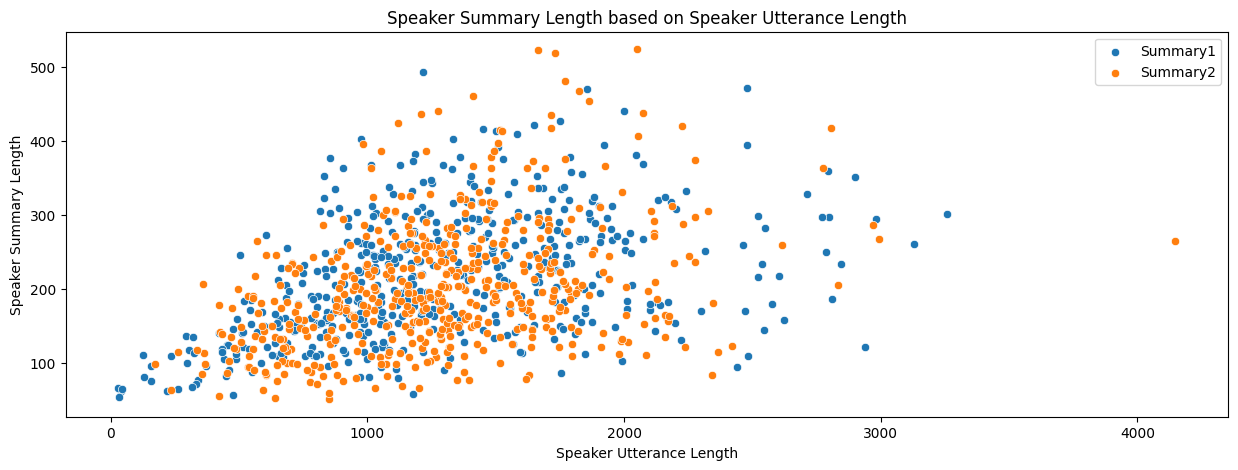

In [33]:
visualize_speaker_summary_length(structured_train_df)

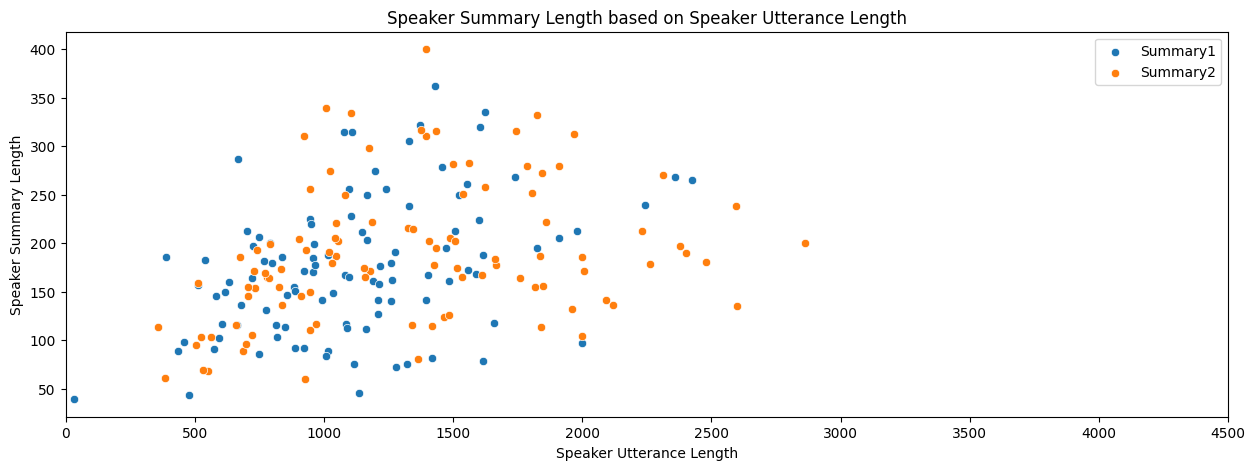

In [200]:
structured_dev_df = split_structured_summary(dev_df)
visualize_speaker_summary_length(structured_dev_df)

<br/>

<br/>

## comma의 역할 파악

In [69]:
def get_comma_word(df: pd.DataFrame):
    """
    Get the number of utterances per speaker in the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame of the data.
    """
    df = deepcopy(df)

    temp = defaultdict(int)

    def add_count(x):
        for i in (re.findall(r'\w*,', x)):
            temp[i] += 1

    df['output'].apply(add_count)
    print(sorted(temp.items(), key = lambda x : x[1], reverse = True))


In [70]:
get_comma_word(train_df)
get_comma_word(dev_df)

[('말했고,', 168), ('또한,', 41), ('있고,', 26), ('했고,', 16), ('같고,', 14), ('있으며,', 13), ('하고,', 12), ('있는데,', 11), ('있지만,', 10), ('또,', 8), ('싶고,', 8), ('하지만,', 7), ('좋고,', 7), ('물었고,', 7), ('없고,', 6), ('때,', 6), ('이야기했으며,', 5), ('좋아하지만,', 5), ('싶으며,', 5), ('했으며,', 5), ('좋지만,', 5), ('않지만,', 5), ('먹고,', 5), ('한편,', 5), ('좋아하고,', 4), ('추천했고,', 4), ('추억,', 4), ('했지만,', 4), ('여행지,', 4), ('싶지만,', 4), ('특히,', 4), ('없지만,', 4), ('했었고,', 4), ('편이고,', 4), ('여행,', 4), ('비타민,', 4), ('3,', 4), ('소리,', 4), ('맛있었고,', 4), ('다녔고,', 3), ('음식,', 3), ('않았고,', 3), ('2,', 3), ('엠비티아이,', 3), ('싶었지만,', 3), ('계획,', 3), ('가족이며,', 3), ('않았지만,', 3), ('다만,', 3), ('영양제,', 3), ('오일,', 3), ('생각하며,', 3), ('부산,', 3), ('갔는데,', 3), ('가고,', 3), ('인상적이었고,', 3), ('들었고,', 3), ('있었는데,', 3), ('봤고,', 3), ('하는데,', 3), ('했는데,', 3), ('꼽았고,', 3), ('것이고,', 3), ('말하며,', 3), ('강아지,', 3), ('않고,', 3), ('먹었고,', 3), ('유산균,', 3), ('말하면서,', 3), ('하면서,', 3), ('물어보았고,', 3), ('다녀왔는데,', 3), ('좋아하며,', 2), ('싶다며,', 2), ('카페,', 2), ('활동,', 2), ('이유,', 2